# Setup

### Dependencies

`
pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph beautifulsoup4 langchain-google-genai langchain-huggingface langchain-chroma jupyter ipywidgets tqdm python-dotenv
`

### LangSmith

In [2]:
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

### Components

Chat Model: Google AI

In [3]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2",
                                   cache_folder="huggingface_models")

Vector Store: Chroma

In [6]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings, persist_directory="chroma_db")

# Indexing

### Loading Documents

In [7]:
# from langchain_community.document_loaders import TextLoader
# from pathlib import Path

# # Define the folder where your .txt files are stored
# txt_folder = r"D:\Mahabharat Text"

# # Load all .txt files from the folder
# file_paths = list(Path(txt_folder).glob("*.txt"))

# # Load documents
# docs = [TextLoader(str(file_path)).load()[0] for file_path in file_paths]

# # Print total character count from all files
# total_chars = sum(len(doc.page_content) for doc in docs)
# print(f"Total characters: {total_chars}")


In [8]:
from langchain_community.document_loaders import PyPDFLoader
from pathlib import Path

# Define the folder where your PDF files are stored
pdf_folder = r"./Solder_Bridging_Docs"

# Load all .pdf files from the folder
file_paths = list(Path(pdf_folder).glob("*.pdf"))
# file_paths = [Path(r"./Solder_Bridging_Docs/4.pdf")]

# Load documents
docs = []
for file_path in file_paths:
    loader = PyPDFLoader(str(file_path))
    pages = loader.load()
    docs.extend(pages)  # Append all pages of the PDF

# Print total character count from all files
total_chars = sum(len(doc.page_content) for doc in docs)
print(f"Total characters: {total_chars}")

C:\Users\Ryan\anaconda3\envs\nlp_proj_env\Lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


Total characters: 1020842


In [9]:
print(docs[0].page_content[:1000])

aimsolder.com 1
SMT TROUBLE 
SHOOTING GUIDE



### Splitting Documents

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split all the solder bridging docs text into {len(all_splits)} sub-documents.")

Split all the solder bridging docs text into 1380 sub-documents.


### Adding metadata

In [11]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'Solder_Bridging_Docs\\1.pdf',
 'page': 0,
 'start_index': 0,
 'section': 'beginning'}

In [12]:
all_splits[2].metadata

{'source': 'Solder_Bridging_Docs\\1.pdf',
 'page': 2,
 'start_index': 0,
 'section': 'beginning'}

In [13]:
print(f"No. of splits: {len(all_splits)}")

No. of splits: 1380


### Storing documents

In [14]:
# Batch Insert Approach
batch_size = 100

document_ids = []
for i in range(0, len(all_splits), batch_size):
    batch = all_splits[i:min((i + batch_size), len(all_splits))]
    batch_ids = vector_store.add_documents(documents=batch)
    document_ids.extend(batch_ids)
    print(f"Inserted {min(i + batch_size, len(all_splits))}/{len(all_splits)} documents")

print(document_ids[:3])

Inserted 100/1380 documents
Inserted 200/1380 documents
Inserted 300/1380 documents
Inserted 400/1380 documents
Inserted 500/1380 documents
Inserted 600/1380 documents
Inserted 700/1380 documents
Inserted 800/1380 documents
Inserted 900/1380 documents
Inserted 1000/1380 documents
Inserted 1100/1380 documents
Inserted 1200/1380 documents
Inserted 1300/1380 documents
Inserted 1400/1380 documents
['4d4a994b-9d13-4ab6-9fa3-e4bf50ef00ef', '1076e1d8-8f6d-44e8-b649-1172fb7eb777', '2158b735-22fa-483c-b5e9-8c2852a7f76d']


# Query Analysis

In [15]:
from typing import Literal
from pydantic import BaseModel, Field

class Search(BaseModel):
    """Search query."""
    query: str = Field(description="Search query to run.")
    section: Literal["beginning", "middle", "end"] = Field(description="Section to query.")

In [16]:
from langchain.prompts import PromptTemplate

custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are an expert AI assistant specializing in answering complex questions using retrieved context.
Your goal is to provide a detailed, structured, and well-formatted response with markdown elements.

### Question:
{question}

### Context:
{context}

### Answer:
- **Detailed Explanation:** Provide an in-depth response with supporting details using only the details given in the context.
- **Bullet Points & Formatting:** Use bullet points, subheadings, and code blocks when relevant.
- **Step-by-Step Breakdown:** If applicable, break down the answer into logical steps.
- **Examples & Analogies:** Where helpful, give real-world examples or analogies.

If the context does not contain enough information, state: "**The provided context does not have sufficient details.**"
""",
)

example_messages = custom_prompt.format(
    context="(context goes here)",
    question="(question goes here)"
)
print(example_messages)


You are an expert AI assistant specializing in answering complex questions using retrieved context.
Your goal is to provide a detailed, structured, and well-formatted response with markdown elements.

### Question:
(question goes here)

### Context:
(context goes here)

### Answer:
- **Detailed Explanation:** Provide an in-depth response with supporting details using only the details given in the context.
- **Bullet Points & Formatting:** Use bullet points, subheadings, and code blocks when relevant.
- **Step-by-Step Breakdown:** If applicable, break down the answer into logical steps.
- **Examples & Analogies:** Where helpful, give real-world examples or analogies.

If the context does not contain enough information, state: "**The provided context does not have sufficient details.**"



# Retrieval & Generation

### LangGraph

State

In [17]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

Nodes

In [18]:
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query.query,
        k = 5,
        filter={"section": query.section},
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Control Flow

In [19]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

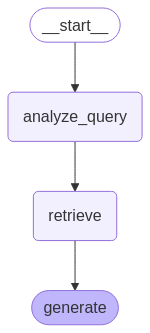

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Testing

In [21]:
result = graph.invoke({"question": "What are defects that can be associated with lead-free reflow soldering?"})         # Answer in Page 3   of 4.pdf

print(f'Answer: {result["answer"]}')

print(f'\n\nContext:-')
print(f"No. of docs in context: {len(result["context"])}")

for i, doc in enumerate(result["context"]):
    print(f"\nDoc {i}:")
    print(doc)

Answer: The provided text lists the following defects associated with lead-free reflow soldering:

* **Bridging:**  Solder forms a bridge connecting two adjacent solder joints that should be separate.
* **Solder Balls:** Small spheres of solder separate from the main solder joint.
* **Mid-chip Balling:**  A specific type of solder balling that occurs under a component, particularly BGA components.
* **Poor Wetting:**  The solder does not adhere properly to the surfaces it is meant to join, resulting in a weak connection.
* **Voids:**  Empty spaces or pockets within the solder joint, which can weaken the joint and affect its reliability.
* **Tombstoning:** One end of a component lifts off the board during reflow, resembling a tombstone.
* **De-wetting:** The solder pulls away from the surface it is meant to join, leaving exposed areas.


The text emphasizes that these defects are often *not* an inherent problem of lead-free soldering itself, but rather a consequence of a poorly implemen

In [22]:
result = graph.invoke({"question": "What are the potential failure modes during lead-free reflow soldering?"})         # Answer in Page 3   of 4.pdf

print(f'Answer: {result["answer"]}')

print(f'\n\nContext:-')
print(f"No. of docs in context: {len(result["context"])}")

for i, doc in enumerate(result["context"]):
    print(f"\nDoc {i}:")
    print(doc)

Answer: Potential failure modes during lead-free reflow soldering, according to the provided text, include:

* **Bridging:** Solder bridging between adjacent component leads or solder pads.
* **Solder Balls:** Formation of small solder spheres separate from the solder joint.
* **Mid-chip Balling:**  Solder balling specifically occurring under a component's body (mid-chip).
* **Poor Wetting:** Insufficient wetting of the solder to the component leads and/or PCB pads.
* **Voids:** Formation of air pockets within the solder joint.
* **Tombstoning:** One end of a component lifting off the PCB pad during reflow, resembling a tombstone.
* **De-wetting:**  The solder retracting or pulling away from the surface it is supposed to bond to, leaving exposed areas.
* **Cracking:** Due to higher stiffness and lower ductility of lead-free solders, cracking can occur under thermal stress.
* **Compatibility Issues:**  Some lead-free solder alloys may not be compatible with certain components or PCB fin

Listing all the steps in the graph stream

In [ ]:
for step in graph.stream(
        {"question": "Why does lead-free reflow show poor wetting?"}, stream_mode="updates"             # Answer in Page 5 of 4.pdf
):
    print(f"{step}\n\n----------------\n")

In [ ]:
for message, metadata in graph.stream(
        {"question": "What are some causes of voids in joints?"}, stream_mode="messages"
):
    print(message.content, end="|")